In [1]:
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

from IPython.display import HTML
import matplotlib.cm as cm
import numpy as np
from typing import Union
import math


In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from lib.model_reduction_variant import Extractor
from lib.anomaly_detection import LOCIMatrix, LOCIMatrixNew
from lib.model_utils import export_rules_to_csv
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
pd.options.display.notebook_repr_html = False 
plt.rcParams['figure.dpi'] = 75 
sns.set_theme(style='darkgrid') 

In [3]:
from lib.model_utils import ModelUtil
model = ModelUtil(data_name = 'german_credit', model_name = 'RF')
paths = model.paths
cond_mat, output = model.get_rule_matrix()


/home/lizhen/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Test
Accuracy Score is 0.828
Precision Score is 0.8663101604278075
F1 Score is 0.88283378746594
Train
Accuracy Score is 0.8932692307692308


In [4]:
high_conf_idxes = [i for i, p in enumerate(paths) if paths[i]['confidence'] > 0.8]

import copy
feature_pos = copy.deepcopy(model.feature_pos)

is_feature_categorical = {}
feature_val_idxs = {}
for i in model.feature_pos:
    if i == -1:
        continue
    feature, index = model.feature_pos[i]
    is_feature_categorical[feature] = index > 0

for i in model.feature_pos:
    if i == -1:
        continue
    feature, index = model.feature_pos[i]
    if is_feature_categorical[feature]:
        if feature not in feature_val_idxs:
            feature_val_idxs[feature] = []
        if i >= 0:
            feature_val_idxs[feature].append(i)

is_categorical = []
feature_range = []
for i in model.feature_pos:
    if i == -1:
        continue
    feature, index = model.feature_pos[i]
    is_categorical.append(is_feature_categorical[feature])
    feature_range.append(model.feature_range[feature])

n_features = len(is_categorical)
to_category_idx = [3]
for i in to_category_idx:
    name = model.feature_pos[i][0]
    is_categorical[i] = True
    feature_len =  model.feature_range[name][1] - model.feature_range[name][0]
    idx = [i] + [j for j in range(n_features, n_features + feature_len - 1)]
    for it, j in enumerate(idx):
        feature_pos[j] = (name, it)
        is_categorical.append(True)
    feature_val_idxs[name] = idx
    n_features += feature_len - 1

X = np.ones((len(paths), n_features)).astype('float') * 0.5
y = np.ones((len(paths), ))

mid = np.zeros((n_features)).astype('float')
columns = [feature for feature in model.data_table.columns if feature != model.target]
n_samples = len(model.data_table)
for i, feature in enumerate(columns):
    if is_categorical[i]:
        if i in to_category_idx:
            vmin = model.data_table[feature].min()
            vmax = model.data_table[feature].max()
            for k, j in enumerate(feature_val_idxs[feature]):
                val = (model.data_table[feature] == k + vmin).sum() / n_samples
                mid[j] = val
        else:
            _, k = feature_pos[i]
            vmin = model.data_table[feature].min()
            mid[i] = (model.data_table[feature] == 1).sum() / n_samples

for row_i, p in enumerate(paths):
    m = p['range']
    row = mid.copy()
    for i in m:
        if is_categorical[i]:
            feature, _ = model.feature_pos[i]
            idx = feature_val_idxs[feature]
            if i in to_category_idx:
                ll = feature_range[i][0]
                rr = feature_range[i][1]
                left = int(max(ll, math.floor(m[i][0])))
                right = int(min(rr, math.ceil(m[i][1])))
                if ll > 0:
                    left -= ll
                    right -= ll
                    rr -= ll
                    ll = 0
                rr = min(rr, len(idx))
                right = min(right, rr)
                for j in range(rr):
                    row[idx[j]] = 0
                for j in range(left, right):
                    row[idx[j]] = mid[idx[j]]
            else:
                if m[i][1] > 1:
                    if row[idx].sum() == 1:
                        row[idx] = 0
                    row[i] = mid[i]
                else:
                    row[i] = 0
        else:
            left = int(max(feature_range[i][0], m[i][0]))
            right = int(min(feature_range[i][1] - 1, m[i][1]))
            left = model.get_sum(i, 1, left) / len(model.X)
            right = model.get_sum(i, 1, right) / len(model.X)
            row[i] = (left + right) / 2 - 0.5
    for feature in feature_val_idxs:
        idx = feature_val_idxs[feature]
        tot = row[idx].sum()
        if tot > 0:
            row[idx] /= tot

    X[row_i] = row
    y[row_i] = p['output']
lr_mat = X

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X[high_conf_idxes], y[high_conf_idxes])
y_pred = lr.predict(X[high_conf_idxes])
from sklearn.metrics import accuracy_score, precision_score, f1_score
print('Accuracy Score is', accuracy_score(y[high_conf_idxes], y_pred))
print('Precision Score is', precision_score(y[high_conf_idxes], y_pred))
print('F1 Score is', f1_score(y[high_conf_idxes], y_pred))

feature_importance = np.abs(lr.coef_[0])

Accuracy Score is 0.921983758700696
Precision Score is 0.9671532846715328
F1 Score is 0.9403415391439344


In [5]:
mat = cond_mat * feature_importance

In [11]:
res = LOCIMatrixNew(mat, r = 0.15, metric = 'euclidean', n_ticks=100, output = output)
res.run()

r range: 0.150 - 1.000


True

1000000


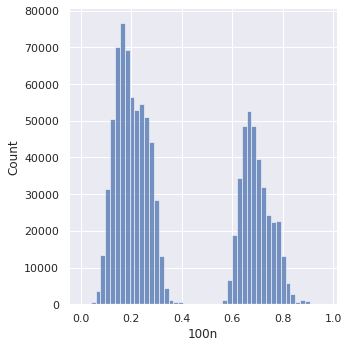

In [7]:
vec = res.sorted_dist[:, 1:].reshape(-1)
vec = vec[:1000000]
print(len(vec))
consistency_data = pd.DataFrame({ '100n': vec })
sns.displot(data=consistency_data, x="100n", bins=50, log_scale=(False, False))
plt.show()

In [8]:
res.rs[11]

0.199

In [9]:
predict_proba = lr.predict_proba(X)
score1 = np.array([predict_proba[i, 1 - int(y[i])] for i in range(predict_proba.shape[0])])

idx = [i for i in range(2, 9000, 10)]
plt.scatter(res.scores[idx, 11], score1[idx], s = 2, color='gray')
plt.show()

In [17]:
score = res.scores[:, 11]
outlier =  score.argsort()[-50:][::-1]

In [18]:
import matplotlib as mpl

class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

for i in model.feature_pos:
    if model.feature_pos[i][0] not in feature_val_idxs:
        feature_val_idxs[model.feature_pos[i][0]] = i
        
max_ctr = lr.coef_[0].max()
min_ctr = -lr.coef_[0].min()
blues = MplColorHelper('Blues', 0, 1)
reds = MplColorHelper('Reds', 0, 1)

def display_rule(id, i, j = -1):
    conds, output = model.interpret_path(model.paths[i])
    vec = lr_mat[i]
    text = '<b>IF </b> '
    for (feature, op, val) in conds:
        idx = feature_val_idxs[feature]
        ctr = np.sum(lr.coef_[0][idx] * vec[idx])
        if ctr > 0:
            ctr /= max_ctr
        else:
            ctr /= min_ctr
        cond_text = feature + ' ' + op + ' ' + str(val)
        if ctr > 0:
            rgb = blues.get_rgb(ctr * 0.9 + 0.1)
        else:
            rgb = reds.get_rgb(-ctr * 0.9 + 0.1)
        
        text_color = 'white' if np.abs(ctr) > 0.15 else 'black'
        bgcolor = 'rgb(%d,%d,%d)' % (int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
        if np.abs(ctr) < 0.03:
            bgcolor = 'white'

        text += ' <span style="background-color: %s; color:%s;">%s</span>, ' % \
            (bgcolor, text_color, cond_text)
    text = text[:-2] + ' '
    text += '<b>THEN </b> ' + output
    info = '#%d, %d, LR: %.2f, Anomaly: %.2f, Neighbors: %d, Cover: %d' % (id, i, score1[i], score[i], res.outer_ptr[i], np.sum(paths[i]['distribution']))
    if j != -1:
        info += ', Same: %d' % np.sum(np.array(paths[i]['sample']) * np.array(paths[j]['sample']))
    display(HTML(info))
    display(HTML(text))


In [119]:
export_rules_to_csv('csv/0715_logistic_regression_top200', model, score1.argsort()[-200:][::-1])

In [103]:
print(res.sorted_dist[6944, 100], res.sorted_dist[:, 100].mean())

0.11076411712903425 0.0996468851039179


In [22]:
print(res.sorted_dist[8868, 100], res.sorted_dist[:, 100].mean())

0.18514989977563434 0.0996468851039179


In [ ]:
for i in range()

In [20]:
for it, i in enumerate(outlier):
    display_rule(it, i)

In [144]:
for it, i in enumerate(np.array(score2).argsort()[:10][::-1]):
    display_rule(it, i)

<div class="alert alert-info">
  <strong>Consistency Top 50 (20 neighbors):</strong>
</div>

In [185]:
r = np.mean(res.sorted_dist[:, 20])
ret20 = res.check_consistency(r, [p['output'] for p in paths])
idx20 = np.array(ret20).argsort()[:50]
for it, i in enumerate(idx20):
    display_rule(it, i) 

<div class="alert alert-info">
  <strong>Consistency Top 50 (50 neighbors):</strong>
</div>

<div class="alert alert-info">
  <strong>Consistency Top 50 (100 neighbors):</strong>
</div>

In [150]:
res = LOCIMatrixNew(mat, r = 0.2, metric = 'cosine', n_ticks=100)
res2 = LOCIMatrixNew(mat, r = 0.2, metric = 'euclidean', n_ticks=100)

In [151]:
consist1 = res.check_consistency(res.sorted_dist[:, 100].mean(), [p['output'] for p in paths])
consist2 = res2.check_consistency(res2.sorted_dist[:, 100].mean(), [p['output'] for p in paths])

In [193]:
consist3 = cond_res.check_consistency(cond_res.sorted_dist[:, 100].mean(), [p['output'] for p in paths])

In [194]:
np.array(consist3).min()

0.044534412955465584

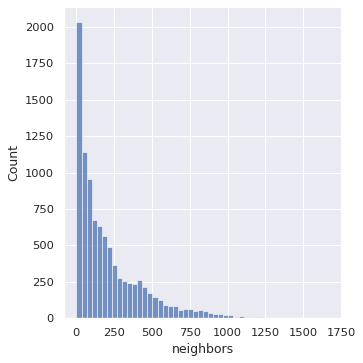

In [195]:
neighbors_data = pd.DataFrame({ 'neighbors': cond_res.outer_ptr })
sns.displot(data=neighbors_data, x="neighbors", bins=50, log_scale=(False, False))
plt.show()

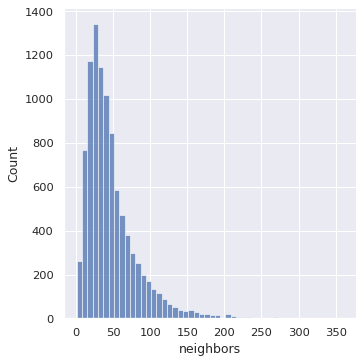

In [213]:
consist2 = res2.check_consistency(res2.sorted_dist[:, 1000].mean(), [p['output'] for p in paths])
neighbors_data2 = pd.DataFrame({ 'neighbors': mat.sum(axis = 1) })
sns.displot(data=neighbors_data2, x="neighbors", bins=50, log_scale=(False, False))
plt.show()

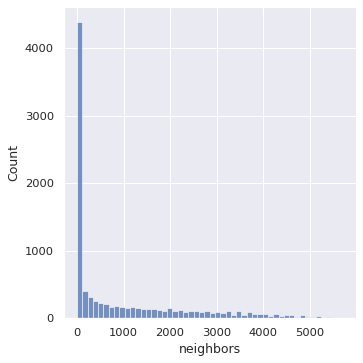

In [214]:
consist2 = res2.check_consistency(res2.sorted_dist[:, 100].mean(), [p['output'] for p in paths])
neighbors_data2 = pd.DataFrame({ 'neighbors': res2.outer_ptr })
sns.displot(data=neighbors_data2, x="neighbors", bins=50, log_scale=(False, False))
plt.show()

In [156]:
np.array(res2.outer_ptr < 10).sum()

2748